In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import requests
import geocoder

import configparser

import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
config = configparser.ConfigParser()
config.read('credentials.ini')

#load Foursquare credentials
CLIENT_ID = config['DEFAULT']['client_id']
CLIENT_SECRET = config['DEFAULT']['client_secret']

# Other configuration
LIMIT = 100
VERSION = '20180605' # follow lab version

# Part 1

Load data from wikipedia page using `read_html` method of pandas.

In [3]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove all unnassigned boroughs.

In [4]:
df = df.loc[~df['Borough'].str.startswith('Not ')]
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Confirm there are no boroughs with `Not assigned` as values.

In [5]:
df.loc[df['Borough'].str.startswith('Not ')]

,Postal Code,Borough,Neighbourhood


Set all neighbourhood with values `Not assigned` as the value of its borough.

In [6]:
df.loc[df['Neighbourhood'].str.startswith('Not ')]
# no rows matched, so skip this process.

,Postal Code,Borough,Neighbourhood


Print dataframe's shape

In [7]:
df.shape

(103, 3)

# Part 2

In [8]:
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Load data from CSV due to failure in getting latitude and longitude from geocoder.

In [9]:
# df['Latitude'] = np.nan
# df['Longitude'] = np.nan

# for postal_code in df['Postal Code']:
#     # initialize your variable to None
#     lat_lng_coords = None

#     # loop until you get the coordinates
#     print(f'Extracting {postal_code}')
#     while(lat_lng_coords is None):
#         g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#         lat_lng_coords = g.latlng
        
#     df.loc[df['Postal Code'] == postal_code, ['Latitude', 'Longitude']] = lat_lng_coords[0], lat_lng_coords[1]

In [10]:
df = df.merge(pd.read_csv('Geospatial_Coordinates.csv'), on='Postal Code')

In [11]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Part 3

In [12]:
import folium

# Visualise datapoints

Create a map, and display the coordinates as points, with Toronto's regions coloured in red.

In [13]:
latitude, longitude = 43.6532, -79.35
m = folium.Map(
    location=[latitude, longitude], zoom_start=15,
    no_touch=True, zoom_control=False, dragging=False, min_zoom=10, max_zoom=10,
    double_clickzoom=False
)

for index, row in df[['Borough', 'Latitude', 'Longitude']].iterrows():
    if 'Toronto' in row['Borough']:
        folium.CircleMarker([row['Latitude'], row['Longitude']], radius=2, color='firebrick').add_to(m)
    else:
        folium.CircleMarker([row['Latitude'], row['Longitude']], radius=2).add_to(m)

m

In [14]:
df.loc[0]

Postal Code             M3A
Borough          North York
Neighbourhood     Parkwoods
Latitude            43.7533
Longitude          -79.3297
Name: 0, dtype: object

In [15]:
# Foursquare url
# type your answer here
url = (
    f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}'
    f'&v={VERSION}&ll={df.loc[0, "Latitude"]},{df.loc[0, "Longitude"]}&radius=500&limit={LIMIT}'
)
# url

In [16]:
r = requests.get(url)

In [17]:
data = r.json()

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = data['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-19-2b8baa831883>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto = getNearbyVenues(
    df.loc[df.Borough.str.contains('Toronto'), 'Neighbourhood'],
    df.loc[df.Borough.str.contains('Toronto'), 'Latitude'],
    df.loc[df.Borough.str.contains('Toronto'), 'Longitude']
)

# toronto = getNearbyVenues(
#     df['Neighbourhood'],
#     df['Latitude'],
#     df['Longitude']
# )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [22]:
toronto.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [23]:
# count of venues in each Neighbourhood
toronto['Neighbourhood'].value_counts()

Richmond, Adelaide, King                                                                                      100
First Canadian Place, Underground city                                                                        100
Garden District, Ryerson                                                                                      100
Harbourfront East, Union Station, Toronto Islands                                                             100
Commerce Court, Victoria Hotel                                                                                100
Toronto Dominion Centre, Design Exchange                                                                      100
Stn A PO Boxes                                                                                                 96
St. James Town                                                                                                 85
Church and Wellesley                                                                    

In [24]:
print(f'There are {toronto["Venue Category"].unique().size} categories in the Toronto area.')

There are 240 categories in the Toronto area.


In [25]:
toronto_onehot = pd.get_dummies(toronto[['Venue Category']], prefix='', prefix_sep='')

toronto_onehot['Neighbourhood'] = toronto['Neighbourhood']

index_to_find = toronto_onehot.columns.tolist().index('Neighbourhood')

fixed_columns = [toronto_onehot.columns[index_to_find]] + list(toronto_onehot.columns[:index_to_find]) + list(toronto_onehot.columns[index_to_find+1:])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.018182,0.0,0.000000,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.014706,0.0,0.000000,0.014706,0.0,0.014706
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
6,Church and Wellesley,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.0,...,0.013333,0.000000,0.0,0.0,0.000000,0.0,0.013333,0.000000,0.0,0.026667
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,...,0.000000,0.000000,0.0,0.0,0.020000,0.0,0.000000,0.010000,0.0,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.029412,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [27]:
toronto_grouped.shape

(39, 241)

In [28]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood'][:15]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.12
1  Breakfast Spot  0.08
2     Coffee Shop  0.08
3       Nightclub  0.08
4       Pet Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1         Auto Workshop  0.06
2           Pizza Place  0.06
3            Comic Shop  0.06
4      Recording Studio  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2  Rental Car Location  0.06
3          Coffee Shop  0.06
4        Boat or Ferry  0.06


----Central Bay Street----
                venue  freq
0         Coff

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Concert Hall,Basketball Stadium
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Gym,Playground,Stadium,Bar,Italian Restaurant,Bakery
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Brewery,Burrito Place,Butcher,Farmers Market,Fast Food Restaurant,Restaurant,Recording Studio,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Department Store,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant


# Clustering

In [31]:
from sklearn.cluster import KMeans

In [32]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [33]:
# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.loc[df['Borough'].str.contains('Toronto'), ['Borough','Neighbourhood', 'Latitude', 'Longitude']].reset_index(drop=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each Neighbourhood
toronto_merged = toronto_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Exploring the Clusters

Let's try and see what are the defining characteristics of each cluster. From the Previous image, we can see one overwhelmingly similar cluster (coloured in light blue), with three distinctly unique clusters (purple, light green and light orange), and a slightly larger cluster coloured in red. Let's generate a word cloud for the two bigger clusters to easily see it's characteristics.

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

## First Cluster

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Bus Line,Swim School,Dim Sum Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0,Sushi Restaurant,Park,Mexican Restaurant,Jewelry Store,Trail,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
33,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Trail,Tennis Court,Playground,Donut Shop,Doner Restaurant,Dog Run,Dumpling Restaurant,Deli / Bodega,Dive Bar


(-0.5, 4999.5, 2499.5, -0.5)

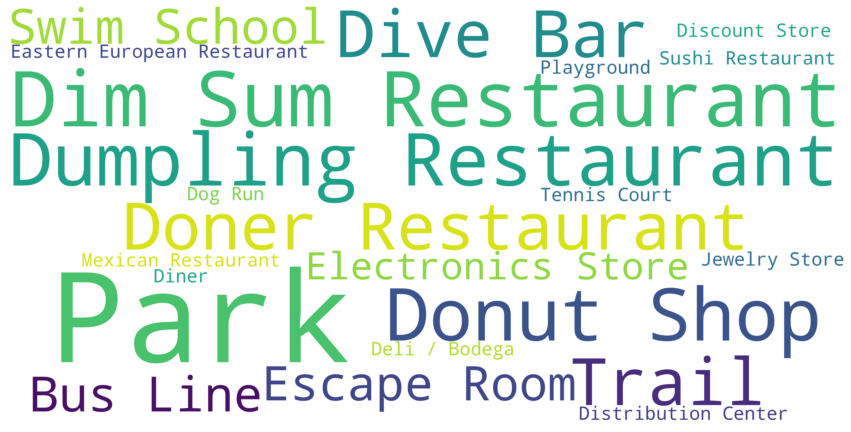

In [37]:
cluster = 0
cluster_list = [j for i in toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].iloc[:, 5:].values for j in i]
wordcloud = WordCloud(background_color='white', width=1000, height=500, scale=5).generate_from_frequencies(frequencies=Counter(cluster_list))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

The first cluster seems to be near locations that offer many different type of physical activities (Park, Escape Rooms, Trails, Playground, Dog Run, Swim School), and also a variety of restaurants.

# Second Cluster

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.38316,1,Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


# Third Cluster

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
3,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
5,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Concert Hall,Basketball Stadium
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Department Store,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant
7,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Restaurant,Candy Store,Athletics & Sports,Italian Restaurant,Baby Store,Coffee Shop,Nightclub
8,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Coffee Shop,Café,Gym,Restaurant,Hotel,Clothing Store,Thai Restaurant,Bar,Sushi Restaurant,Bookstore
9,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Pharmacy,Bakery,Middle Eastern Restaurant,Bank,Bar,Café,Music Venue,Supermarket,Brewery,Park
10,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,2,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Scenic Lookout,Brewery,Pizza Place,Bar


(-0.5, 4999.5, 2499.5, -0.5)

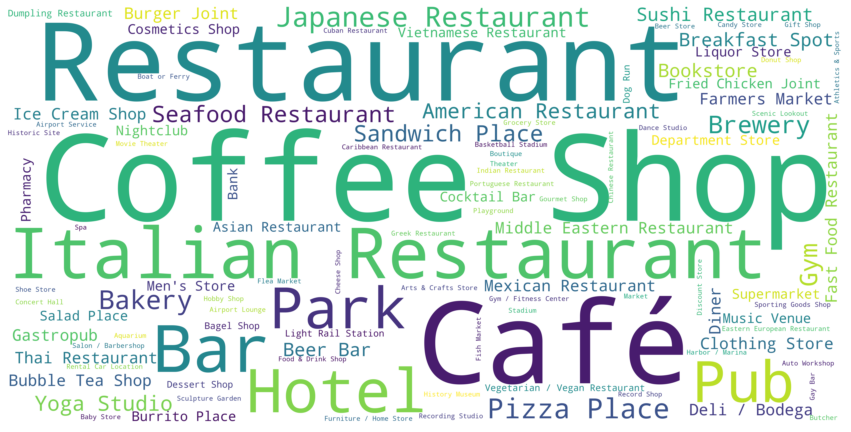

In [40]:
cluster2 = [j for i in toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].iloc[:, 5:].values for j in i]
wordcloud = WordCloud(background_color='white', width=1000, height=500, scale=5).generate_from_frequencies(frequencies=Counter(cluster2))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

The third cluster is primarily centered around coffee shops and cafes, but there's also many other choices foods and drinks that you're almost spoiled for choices.

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,43.711695,-79.416936,4,Dive Bar,Garden,Music Venue,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
